# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [2]:
# Nothing To Do

### Imports


In [3]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [4]:
files = os.listdir(os.curdir + "/files")
parquet_files = []
for file in files:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
        parquet_files.append(file)

In [5]:
df_all = pd.DataFrame(columns=['Dataset', 'Method', 'Fold', 'Value'])

for file in parquet_files:
    core_name = file[len('results_'):-len('.parquet')]
    parts = core_name.split('_')
    if parts[1] == "dataset":
        dataset = parts[0]
        method = parts[2]
        fold = parts[-1]
    elif parts[2] == "dataset":
        dataset = parts[0] + parts[1]
        method = parts[3]
        fold = parts[-1]
    elif parts[3] == "dataset":
        dataset = parts[0] + parts[1] + parts[2]
        method = parts[4]
        fold = parts[-1]
    if method == "xxx":
        print("xxx is not a valid method name")
    else:
        df = pd.read_parquet("files/" + file)
        try:
            df = df[df['status'] == 'success']
            metric_accuracy = df["metric:roc_auc_ovo [0.0, 1.0] (maximize)"].tolist()
            value = np.average(metric_accuracy)
            df_all = df_all._append({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value}, ignore_index=True)
        except KeyError as e:
            print(str(e) + " for file " + str(file))

'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_autogluon_lgbm_classifier_pipeline_1.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_autogluon_lgbm_classifier_pipeline_1.parquet
'status' for file results_madeline_dataset_openfe_lgbm_classifier_pipeline_3.parquet
'status' for file results_madeline_dataset_openfe_lgbm_classifier_pipeline_3.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_h2o_lgbm_classifier_pipeline_0.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_h2o_lgbm_classifier_pipeline_0.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_h2o_lgbm_classifier_pipeline_9.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_h2o_lgbm_classifier_pipeline_9.parquet
'status' for file results_moneyball_dataset_correlationBasedFS_lgbm_classifier_pipeline_2.parquet
'status' for file resu

In [6]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Method'])['Value'].mean().reset_index().fillna(0)
print(df_summary)

              Dataset              Method     Value
0             abalone            autofeat  0.813284
1             abalone           autogluon  0.959551
2             abalone           bioautoml  0.933732
3             abalone              boruta  0.887181
4             abalone  correlationBasedFS  0.871825
..                ...                 ...       ...
164  winequalitywhite                 h2o  0.881967
165  winequalitywhite              mafese  0.497010
166  winequalitywhite               mljar  0.886400
167  winequalitywhite              openfe  0.874528
168  winequalitywhite            original  0.806756

[169 rows x 3 columns]


In [7]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)
print(df_summary)

              Dataset              Method     Value    StdDev  \
0             abalone            autofeat  0.813284  0.093089   
1             abalone           autogluon  0.959551  0.052766   
2             abalone           bioautoml  0.933732  0.021261   
3             abalone              boruta  0.887181  0.048281   
4             abalone  correlationBasedFS  0.871825  0.062477   
..                ...                 ...       ...       ...   
164  winequalitywhite                 h2o  0.881967  0.134722   
165  winequalitywhite              mafese  0.497010  0.000000   
166  winequalitywhite               mljar  0.886400  0.119438   
167  winequalitywhite              openfe  0.874528  0.000000   
168  winequalitywhite            original  0.806756  0.094919   

                             Value_with_StdDev  
0     0.8132843117909951 ± 0.09308910011081249  
1    0.9595507253818492 ± 0.052766378112794075  
2    0.9337321537950015 ± 0.021260912403221022  
3     0.887180589121228

In [8]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Method', values='Value_with_StdDev').fillna('Failed')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+----+------------------------+---------------------------------------------+-------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+
|    |        Dataset         |                  autofeat                   |                 autogluon                 |                 bioautoml                 |                   boruta                   |            correlationBasedFS             |                featurewiz                 |                    h2o                    |                   macfe                   |                   mafese                   |    

### Boxplots

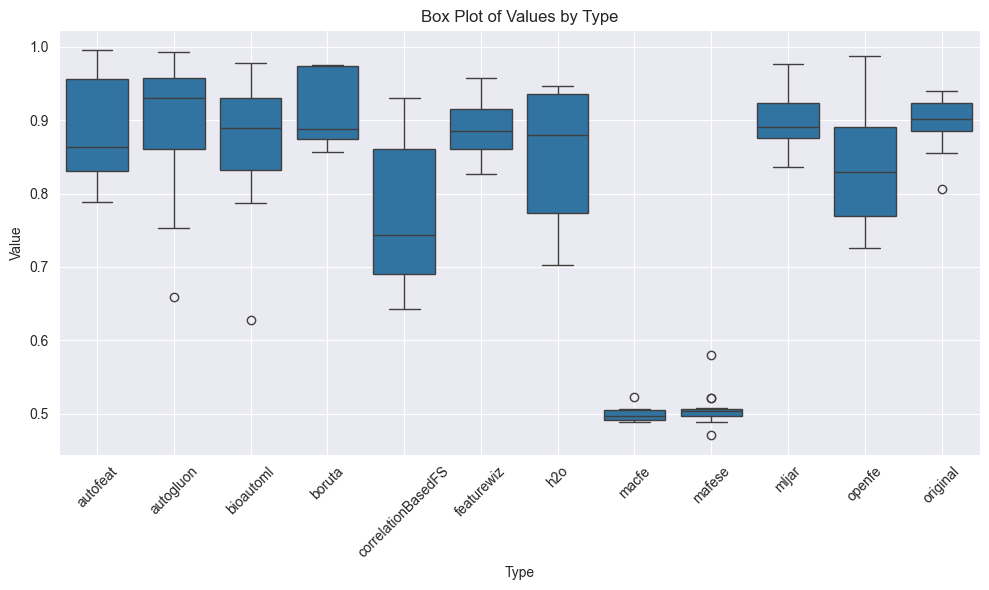

In [9]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()

[5, 10, 7, 9, 1, 7, 8, 0, 0, 7, 4]


/var/folders/p9/q_n4s9cj6m15m7f_8tvsd0380000gn/T/ipykernel_9541/1508477008.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=90, ha='right')


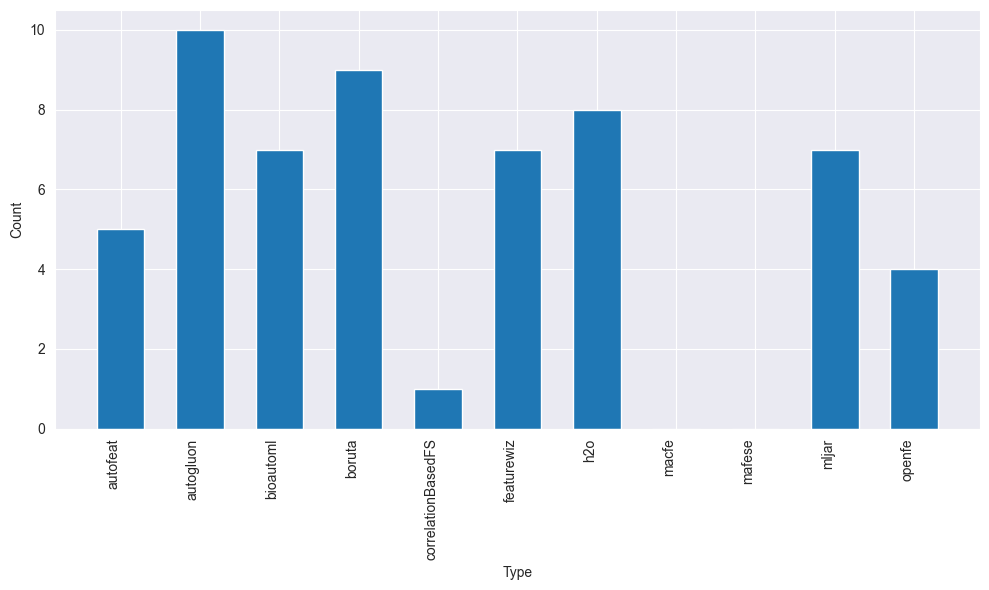

In [10]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

methods = list(pivot_table_numeric.columns[1:-1])
counts = [0] * len(methods)  # Initialize a list with the same length as the number of methods

for method_counter, method in enumerate(methods):  # Use enumerate to keep track of the index
    for i, value in enumerate(pivot_table_numeric[method].values):
        if value > pivot_table_numeric["original"].values[i]:  
            counts[method_counter] += 1  # Increment the count for the method if the condition is met

print(counts)

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size
ax.bar(methods, counts, width=0.6)  # Decrease the bar width to add space between bars

ax.set_xlabel("Type")
ax.set_ylabel("Count")
ax.set_xticklabels(methods, rotation=90, ha='right')
ax.grid(True)

plt.tight_layout()  # Ensure everything fits without overlap
plt.savefig('plots/bar_chart_methods.png')
plt.show()

0.8132843117909951
0.9210056971732782
0.9595507253818492
0.9210056971732782
0.9337321537950015
0.9210056971732782
0.8871805891212288
0.9210056971732782
0.8718249558849116
0.9210056971732782
0.8547477374098723
0.9210056971732782
0.923193786596546
0.9210056971732782
nan
0.9210056971732782
0.5069378199840331
0.9210056971732782
0.9065366690453756
0.9210056971732782
0.7261306499658575
0.9210056971732782
0.8633481755274228
0.8938936071582919
0.7768502496875963
0.8938936071582919
0.9269747533297815
0.8938936071582919
0.8806502079824351
0.8938936071582919
0.8485029033143373
0.8938936071582919
0.8594210428915731
0.8938936071582919
0.7320320772623131
0.8938936071582919
0.4997148311456968
0.8938936071582919
0.504740603546007
0.8938936071582919
0.9105497149501564
0.8938936071582919
0.7800878785779988
0.8938936071582919
nan
0.8553636225506471
0.7530751795022829
0.8553636225506471
0.8849653404795725
0.8553636225506471
0.8594797528446406
0.8553636225506471
nan
0.8553636225506471
0.8624236366543483
0.

/var/folders/p9/q_n4s9cj6m15m7f_8tvsd0380000gn/T/ipykernel_9541/930186998.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(datasets, rotation=90, ha='right')


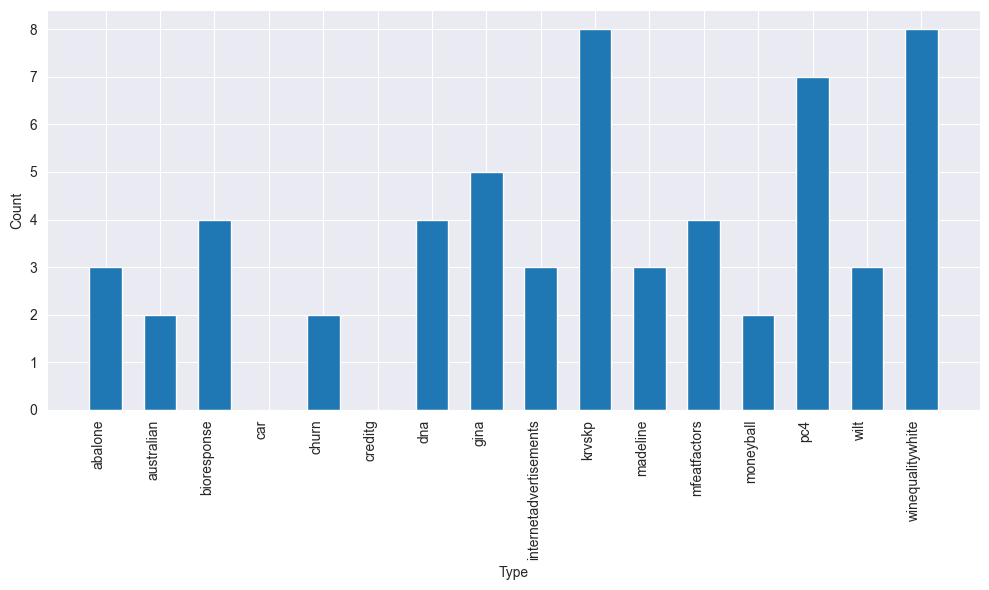

In [28]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

methods = list(pivot_table_numeric.columns[1:-1])
datasets = pivot_table_numeric["Dataset"].to_list()
counts = [0] * len(datasets) 

for dataset_counter, dataset in enumerate(datasets):
    for method in methods:
        print(pivot_table_numeric[method].iloc[dataset_counter])
        print(pivot_table_numeric["original"].iloc[dataset_counter])
        if pivot_table_numeric[method].iloc[dataset_counter] > pivot_table_numeric["original"].iloc[dataset_counter]:  
            counts[dataset_counter] += 1  

print(counts)

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size
ax.bar(datasets, counts, width=0.6)  # Decrease the bar width to add space between bars

ax.set_xlabel("Type")
ax.set_ylabel("Count")
ax.set_xticklabels(datasets, rotation=90, ha='right')
ax.grid(True)

plt.tight_layout()  # Ensure everything fits without overlap
plt.savefig('plots/bar_chart_datasets.png')
plt.show()